<a href="https://colab.research.google.com/github/HerishBadal/smply/blob/master/lawnmower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lawnmower

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/lawnmower.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

The simplest method for _coverage_ is the "lawnmower" pattern, back and forth in strips.  Sounds simple but it can become slightly complicated for weird shaped fields.  This notebook uses the [`shapely` Python library](https://shapely.readthedocs.io/en/stable/) to do the necessary manipulation of shapes, especially splitting and rotating.

> This is technically termed the _boustrophedon_ from the Greek "the way the ox turns" in reference to ploughing a field

In [1]:
import shapely
import shapely.ops
import shapely.plotting
import shapely.affinity
from shapely.geometry import Polygon
import numpy
import matplotlib.pyplot as plt
from pyproj import Transformer
import re






Begin by defining a polygon. Cover long,late -> to deceimal -> to UTM (x,y)

In [2]:


# --- 1. Setup the Coordinate Projection ---
# EPSG:32719 (UTM Zone 19S) is for Chile/Bolivia.
to_meters = Transformer.from_crs("EPSG:4326", "EPSG:32719", always_xy=True)

# --- 2. The Translator Function ---
def dms_to_decimal(dms_str):
    """Converts 23°21'45"S to -23.3625"""
    # Regex finds: numbers, degrees, minutes, seconds, and direction (N/S/E/W)
    # match = re.match(r"(\d+)°(\d+)'(\d+)\"([NSEW])", dms_str.strip())

    # Allow decimal seconds: (\d+(?:\.\d+)?)
    match = re.match(r"(\d+)°(\d+)'(\d+(?:\.\d+)?)\"([NSEW])", dms_str.strip())
    if not match:
        raise ValueError(f"Format not recognized: {dms_str}")

    d, m, s, direction = match.groups()
    decimal = float(d) + float(m)/60 + float(s)/3600

    if direction in ['S', 'W']:
        decimal *= -1
    return decimal

# --- 3. Input Your Raw Data Here ---
# I have ordered these points (1 -> 2 -> 4 -> 3) so the shape
# connects in a circle and does not cross itself.
#-----old data----
#23°21'46"S 67°43'55"W
#23°21'44"S 67°43'52"W
#23°21'46"S 67°43'49"W
#23°21'49"S 67°43'52"W

raw_data = """
23°21'44.95"S 67°43'54.74"W
23°21'45.02"S 67°43'50.65"W
23°21'48.01"S 67°43'50.57"W
23°21'47.98"S 67°43'54.80"W

"""

# --- 4. Parse and Convert ---
gps_coords = []
for line in raw_data.strip().split('\n'):
    parts = line.split() # Splits the line into [LatString, LonString]
    if len(parts) >= 2:
        # Note: We append as (Longitude, Latitude) because Shapely uses X,Y
        lat_dec = dms_to_decimal(parts[0])
        lon_dec = dms_to_decimal(parts[1])
        gps_coords.append((lon_dec, lat_dec))

# --- 5. Convert to Meters & Create Polygon ---
# Transform (Lon, Lat) -> (Eastings, Northings)
meter_coords = [to_meters.transform(lon, lat) for lon, lat in gps_coords]


def verify_coordinates(gps_list, meter_list):
    print("\n--- COORDINATE VERIFICATION ---")
    print(f"{'#':<3} | {'Longitude (Decimal)':<18} | {'Latitude (Decimal)':<18} | {'Easting (X) m':<15} | {'Northing (Y) m':<15}")
    print("-" * 80)

    for i, (gps, meter) in enumerate(zip(gps_list, meter_list)):
        # gps is (Lon, Lat), meter is (X, Y)
        lon, lat = gps
        x, y = meter
        print(f"{i+1:<3} | {lon:<18.6f} | {lat:<18.6f} | {x:<15.2f} | {y:<15.2f}")

    print("-" * 80)
    print("Check: If Easting/Northing are huge numbers (e.g., 600,000+), the projection works.\n")

# --- EXECUTE VERIFICATION ---
verify_coordinates(gps_coords, meter_coords)



# Create the Shapely Polygon
my_poly = shapely.Polygon(meter_coords)

# --- NOW 'my_poly' IS READY FOR YOUR LAWNMOWER FUNCTION ---


--- COORDINATE VERIFICATION ---
#   | Longitude (Decimal) | Latitude (Decimal) | Easting (X) m   | Northing (Y) m 
--------------------------------------------------------------------------------
1   | -67.731872         | -23.362486         | 629617.36       | 7415783.33     
2   | -67.730736         | -23.362506         | 629733.48       | 7415780.16     
3   | -67.730714         | -23.363336         | 629734.94       | 7415688.18     
4   | -67.731889         | -23.363328         | 629614.84       | 7415690.16     
--------------------------------------------------------------------------------
Check: If Easting/Northing are huge numbers (e.g., 600,000+), the projection works.



Our first task is to divide it into segments of equal width, done using shapely's `split` command.

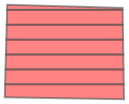

In [11]:
def split_poly(poly,width):
    x_min,y_min,x_max,y_max = poly.bounds
    y_splits = numpy.arange(y_min+width,y_max,width)
    res = poly
    for y in y_splits:
        split_line = shapely.LineString([(x_min,y),(x_max,y)])
        res = shapely.MultiPolygon(shapely.ops.split(res,split_line))
    return res

splits = split_poly(my_poly,15)
splits

### 2. Finding Area after creating the Shapely Polygon (using `my_poly`)


In [13]:
# Area of the polygon
area = my_poly.area

# Bounding box coordinates (min_x, min_y, max_x, max_y)
min_x, min_y, max_x, max_y = my_poly.bounds

# Width and Height from the bounding box
width_from_poly = max_x - min_x
height_from_poly = max_y - min_y

print(f"Area of the polygon: {area:.2f} square meters")
print(f"Width of the polygon (bounding box): {width_from_poly:.2f} meters")
print(f"Height of the polygon (bounding box): {height_from_poly:.2f} meters")

Area of the polygon: 10936.01 square meters
Width of the polygon (bounding box): 120.10 meters
Height of the polygon (bounding box): 95.15 meters


For a typical drone surveying mission, we need to cover each of those segments with our camera field of view.  This means we need to place rectangular strips over each segment, to make sure we don't miss anything.

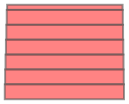

In [4]:
def make_strips(splits):
    return shapely.MultiPolygon([g.envelope for g in splits.geoms])

strips = make_strips(splits)
strips

Next we need to build a path that covers every strip.  The simplest way is to take the strips in the order they were generated, alternating direction each time.

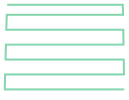

In [5]:
def build_path_simple(strips):
    points = []
    for i,s in enumerate(strips.geoms):
        x_min,y_min,x_max,y_max = s.bounds
        pt_left = shapely.Point(x_min,0.5*(y_min+y_max))
        pt_right = shapely.Point(x_max,0.5*(y_min+y_max))
        if i%2==0:
            points.append(pt_left)
            points.append(pt_right)
        else:
            points.append(pt_right)
            points.append(pt_left)
    return shapely.LineString(points)

path = build_path_simple(strips)
path

Weird?  Let's look at it on a clearer plot.

Text(0.5, 1.0, 'Length=912.6')

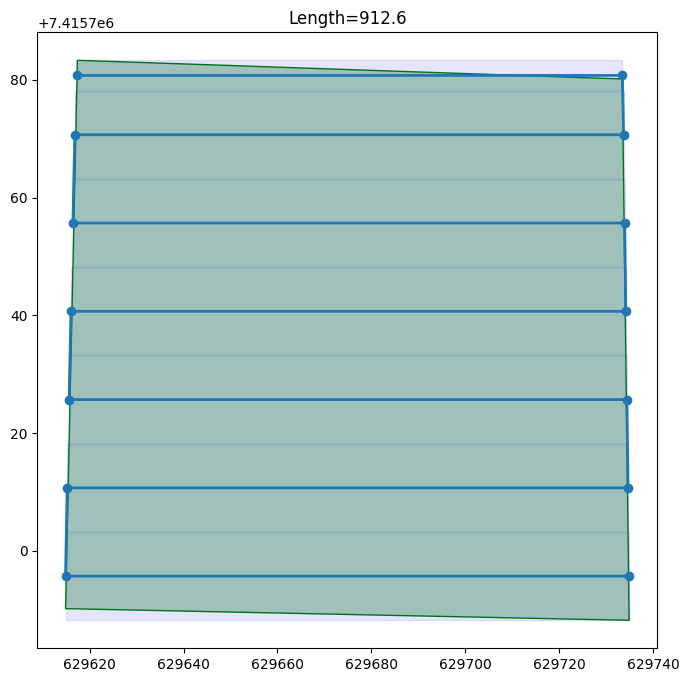

In [6]:
_, ax =plt.subplots(figsize=(8,8))
shapely.plotting.plot_polygon(my_poly,ax=ax,color='g',add_points=False)
shapely.plotting.plot_polygon(strips,ax=ax,color='b',alpha=0.1,add_points=False)
shapely.plotting.plot_line(path,ax=ax)
ax.set_title(f'Length={path.length:.1f}')

It seems we cannot rely upon the splitting algorithm to produce an efficient order.  A better way would be to to a greedy search, starting from one point and always moving to the nearest uncovered strip.

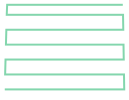

In [7]:
def build_path_greedy(strips):
    pairs = []
    for i,s in enumerate(strips.geoms):
        x_min,y_min,x_max,y_max = s.bounds
        pt_left = shapely.Point(x_min,0.5*(y_min+y_max))
        pt_right = shapely.Point(x_max,0.5*(y_min+y_max))
        pairs.append((pt_left,pt_right))
    path = []
    current_pt = shapely.Point(0,0)
    while pairs:
        dists = [(current_pt.distance(pt_left),current_pt.distance(pt_right)) for pt_left,pt_right in pairs]
        next_strip = numpy.argmin([min(ds) for ds in dists])
        next_end = numpy.argmin(dists[next_strip])
        path.append(pairs[next_strip][next_end])
        path.append(pairs[next_strip][1-next_end])
        current_pt = pairs[next_strip][1-next_end]
        pairs.pop(next_strip)
    return shapely.LineString(path)

path = build_path_greedy(strips)
path

Looks better, perhaps still a little weird.  A closer look...

Text(0.5, 1.0, 'Length=912.6')

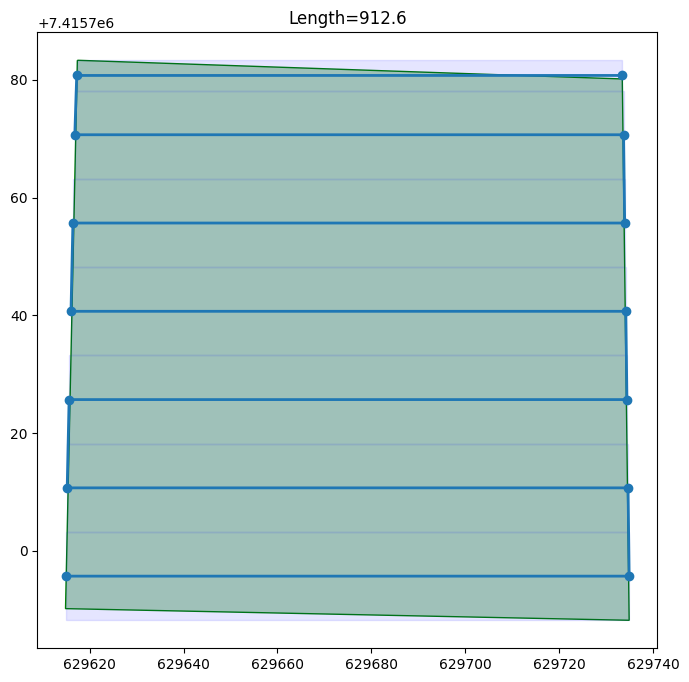

In [8]:
_, ax =plt.subplots(figsize=(8,8))
shapely.plotting.plot_polygon(my_poly,ax=ax,color='g',add_points=False)
shapely.plotting.plot_polygon(strips,ax=ax,color='b',alpha=0.1,add_points=False)
shapely.plotting.plot_line(path,ax=ax)
ax.set_title(f'Length={path.length:.1f}')

That is slightly better, but still obviously odd.  Better still would be to optimize the order - see later examples.

Sticking everything together, we can also include a rotation step, effectively working in a rotated reference frame to make our strips go in a preferred direction.

# Generate way points

In [9]:
# --- STEP E: CONVERT BACK TO GPS & EXPORT ---

# 1. Setup the Reverse Projection (Meters -> GPS)
# We need to turn EPSG:32719 (Meters) back into EPSG:4326 (Lat/Lon)
to_gps = Transformer.from_crs("EPSG:32719", "EPSG:4326", always_xy=True)

print(f"\n--- MISSION SUMMARY ---")
print(f"Total Path Length: {path.length:.2f} meters")
print(f"Number of Waypoints: {len(path.coords)}")
print("-" * 30)
print("LATITUDE, LONGITUDE")

# 2. Iterate through the path points and convert
for i, point in enumerate(path.coords):
    x, y = point
    # Transform X,Y (Meters) -> Lon, Lat
    lon, lat = to_gps.transform(x, y)

    # Print in standard Lat, Lon format (standard for Mission Planner/QGC)
    print(f"{lat:.8f}, {lon:.8f}")

# Optional: Save to a CSV file automatically
import csv
with open('uav_mission_waypoints.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Latitude', 'Longitude']) # Header
    for point in path.coords:
        lon, lat = to_gps.transform(point[0], point[1])
        writer.writerow([lat, lon])

print("\n(File 'uav_mission_waypoints.csv' has been saved)")


--- MISSION SUMMARY ---
Total Path Length: 912.61 meters
Number of Waypoints: 14
------------------------------
LATITUDE, LONGITUDE
-23.36327791, -67.73188936
-23.36326838, -67.73071453
-23.36313294, -67.73071816
-23.36314242, -67.73188720
-23.36300692, -67.73188452
-23.36299749, -67.73072178
-23.36286205, -67.73072541
-23.36287143, -67.73188184
-23.36273593, -67.73187915
-23.36272661, -67.73072903
-23.36259116, -67.73073265
-23.36260044, -67.73187647
-23.36250940, -67.73187337
-23.36250018, -67.73073585

(File 'uav_mission_waypoints.csv' has been saved)


There are clearly some games to be played in optimizing the lawnmower to suit the field.  It gets even weirder when there's wind...

Now, we will take the centriod of each strep assuming we need to stop at the center of each line to do sth like mesureing a gas using a sensor. This will generate way points taht the drone needs to stop there.

In [14]:


# ... (Your previous split_poly function here) ...

# 1. Run your split function
strips = split_poly(my_poly, 15)

# 2. Extract the Centroids (The "Middle" of each strip)
waypoints = []

# Check if result is a MultiPolygon or just a list of Polygons
if isinstance(strips, shapely.geometry.MultiPolygon):
    geoms = strips.geoms
else:
    geoms = [strips]

for strip in geoms:
    # The .centroid property finds the exact geometric center
    center_point = strip.centroid
    waypoints.append((center_point.x, center_point.y))
    print(f"Waypoint: {center_point.x}, {center_point.y}")

# Now 'waypoints' is a list of your 7 stops.

Waypoint: 629666.7798731592, 7415780.079189579
Waypoint: 629675.3257173676, 7415770.67074549
Waypoint: 629675.2420741727, 7415755.670783481
Waypoint: 629675.1584309754, 7415740.670821057
Waypoint: 629675.074787776, 7415725.670858222
Waypoint: 629674.9911445742, 7415710.670894988
Waypoint: 629676.3265323273, 7415696.154609052
